In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'v1_2_1'

base_folder = f'../../data/manager/simulate_rule/{run}'

folder = os.path.join(base_folder, 'train')
merged_folder = os.path.join(base_folder, 'merged')

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)

/Users/levinbrinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

In [4]:
file_names = ['trace.csv']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

sim_df = get_df('trace.csv', merged_folder, folder)

id_vars = ['s', 'b', 'c', 'artificial_humans', 'agent','round_number']
value_vars=['punishments', 'common_good', 'contributions', 'payoffs']

In [5]:
df = sim_df.sort_values(id_vars).copy()

cum_value_vars = [f'cum_{c}' for c in value_vars]

for cum_vv, vv in zip(cum_value_vars, value_vars):
    cumsum = df.groupby(id_vars[:-1])[vv].cumsum()
    cumcount = df.groupby(id_vars[:-1])[vv].cumcount() + 1
    df[cum_vv] = cumsum / cumcount

df_melt = pd.melt(df, id_vars=id_vars, value_vars=value_vars+cum_value_vars, var_name='metric', value_name='value')

df_melt.head()

,s,b,c,artificial_humans,agent,round_number,metric,value
0,0.0,0.0,0.0,complex,0,0,punishments,0.0
1,0.0,0.0,0.0,complex,0,1,punishments,0.0
2,0.0,0.0,0.0,complex,0,2,punishments,0.0
3,0.0,0.0,0.0,complex,0,3,punishments,0.0
4,0.0,0.0,0.0,complex,0,4,punishments,0.0


In [6]:
params = ['metric', 's', 'b','c',]

df = df_melt.groupby(params).sum().reset_index()
best = df.set_index(['s', 'b','c']).groupby(['metric'])['value'].idxmax()
max = df.set_index(['s', 'b','c']).groupby(['metric'])['value'].max()

best = {k: v for k, v in zip(['s', 'b','c'], best['common_good'])}
best

{'s': 1.4, 'b': 0.0, 'c': 1.6}

In [7]:
ref = {'s': 1.0, 'b': 0, 'c': 0}

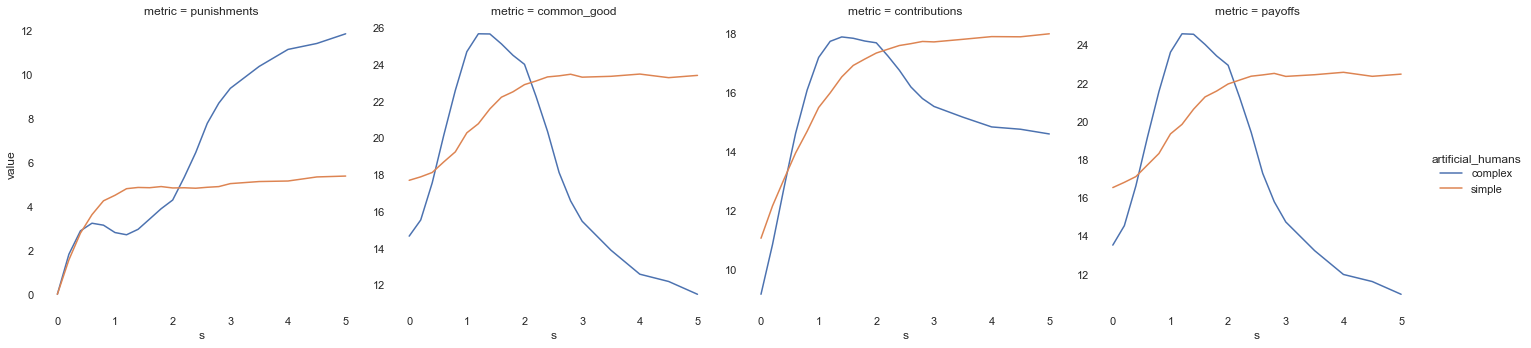

In [8]:
focus = 's'

df = df_melt.copy()

selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = df['metric'].isin(value_vars)

df = df[w & w2]

df.to_parquet('v_1_2_1.parquet')

sns.relplot(data=df, x=focus, y='value', col='metric', hue='artificial_humans', ci=None, facet_kws={'sharey': False, 'sharex': True}, kind='line')

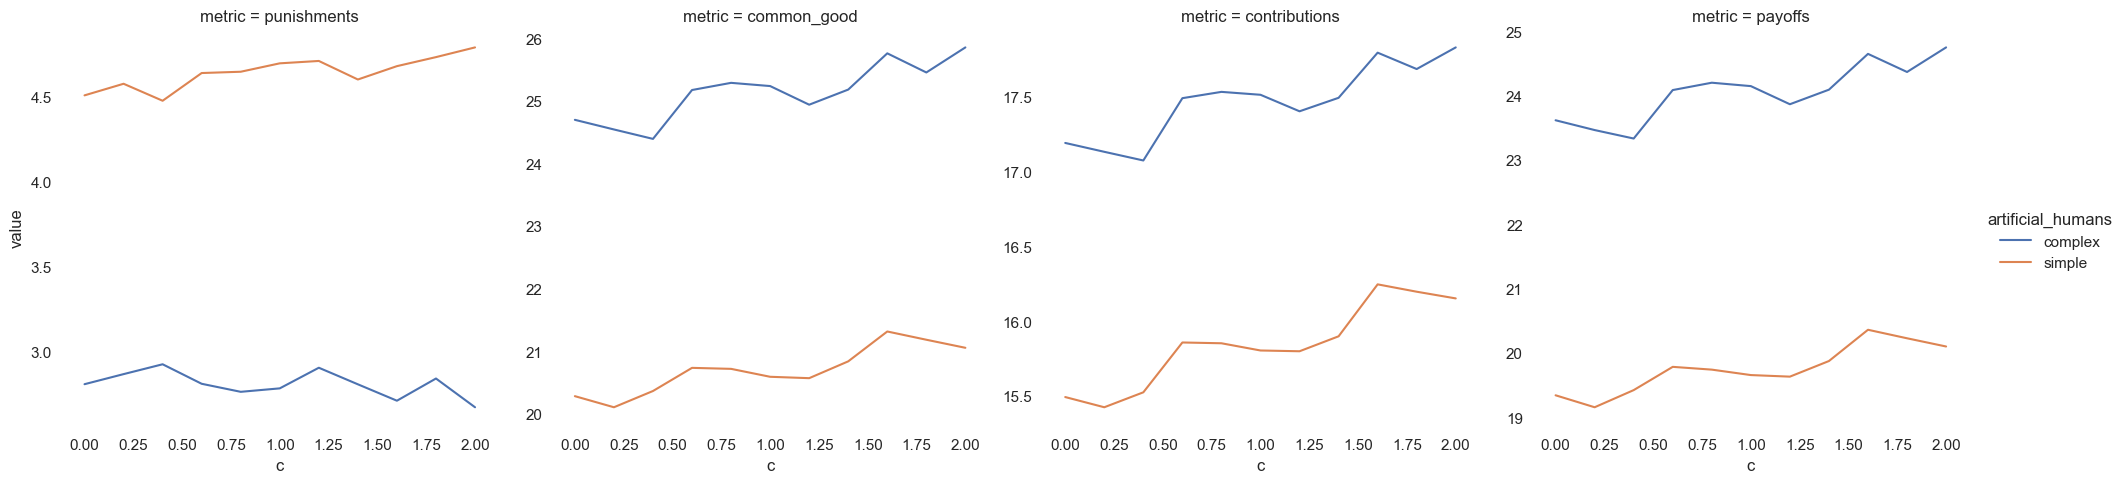

In [9]:
focus = 'c'

df = df_melt.copy()

selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = df['metric'].isin(value_vars)

df = df[w & w2]

sns.relplot(data=df, x=focus, y='value', col='metric', hue='artificial_humans', ci=None, facet_kws={'sharey': False, 'sharex': True}, kind='line')

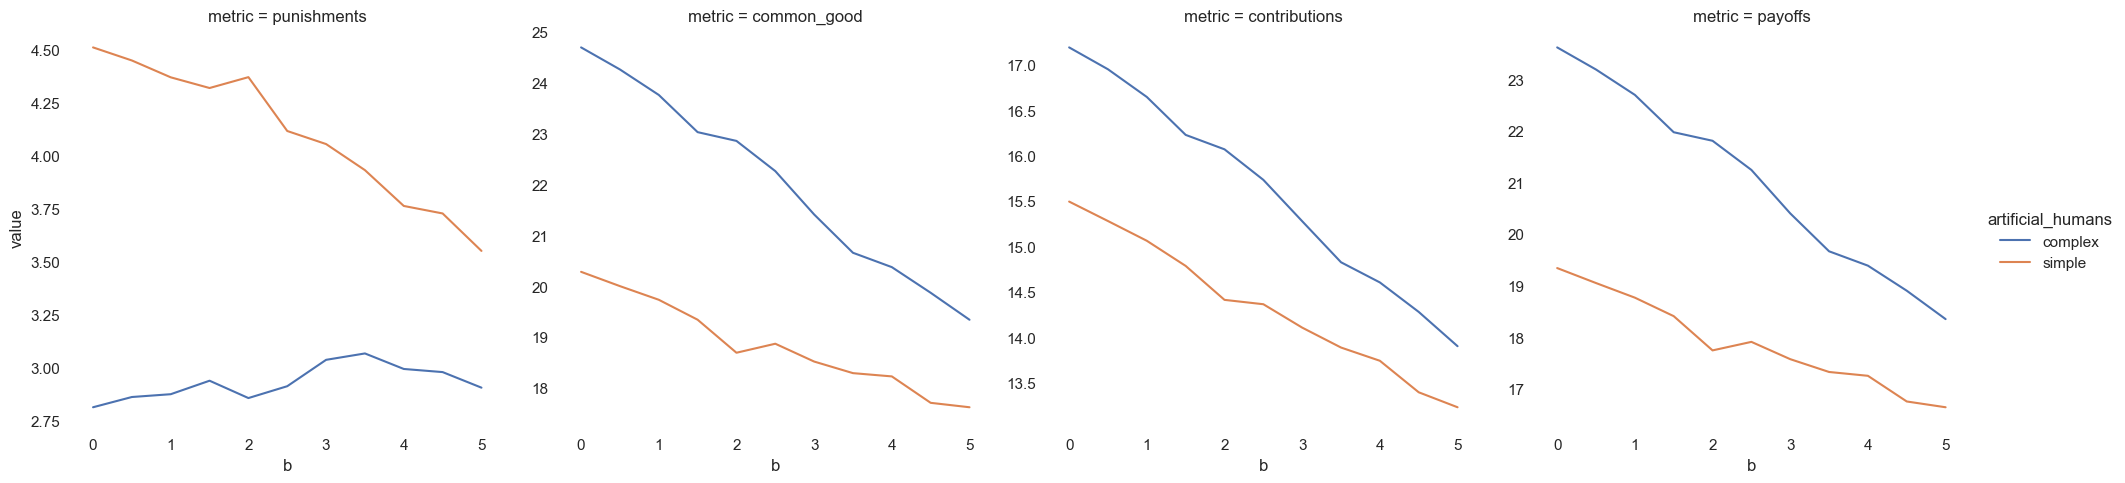

In [10]:
focus = 'b'

df = df_melt.copy()

selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = df['metric'].isin(value_vars)

df = df[w & w2]

sns.relplot(data=df, x=focus, y='value', col='metric', hue='artificial_humans', ci=None, facet_kws={'sharey': False, 'sharex': True}, kind='line')

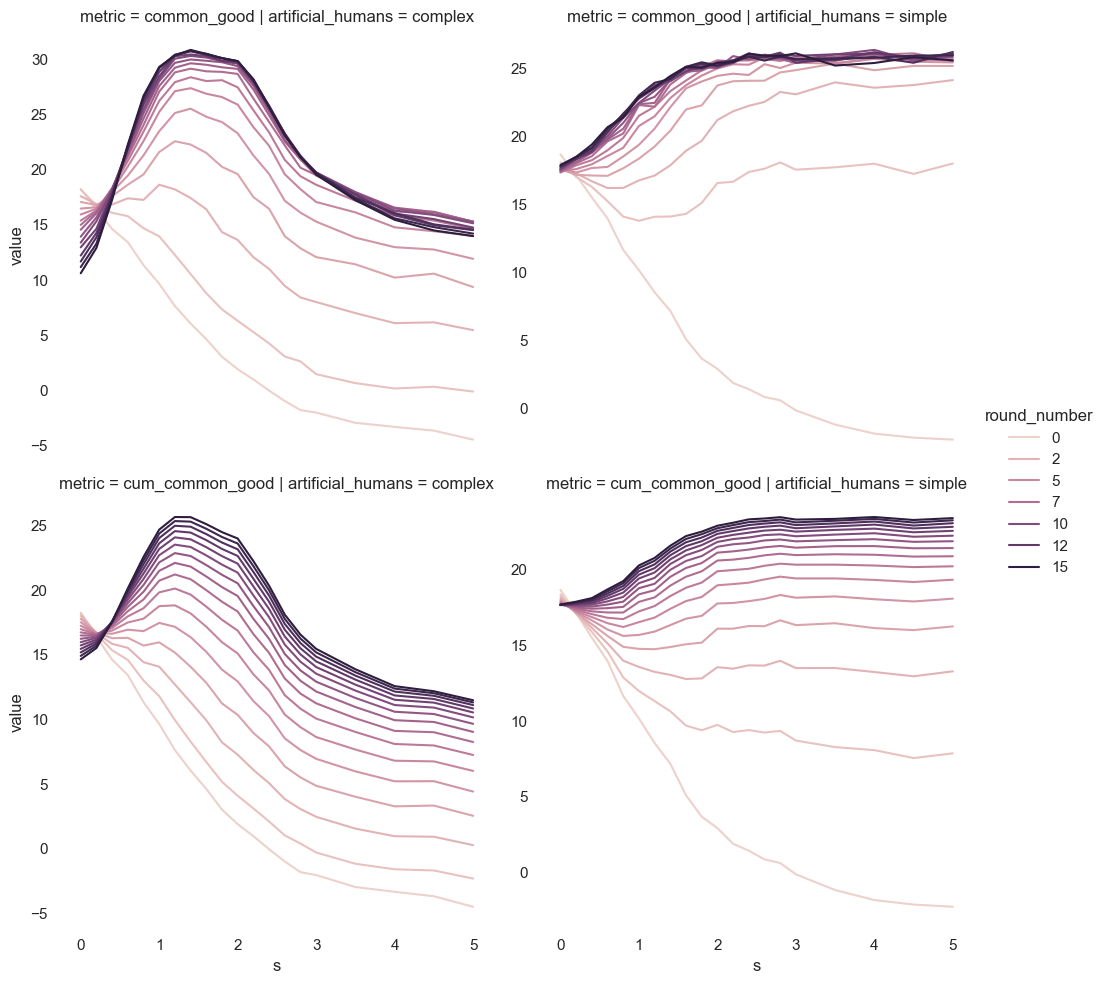

In [11]:
# df = df_melt.groupby(['s', 'metric', 'round_number'])['value'].mean().reset_index()
df = df_melt.copy()

w = (
    (df['c'] == 0) &
    (df['b'] == 0) &
    # df['round_number'].isin([0,1,2,3,7,11,15]) &
    (df['metric'].isin(['common_good', 'cum_common_good']))
)
df = df[w]


sns.relplot(data=df, x='s', y='value', row='metric', col='artificial_humans', hue='round_number', kind='line', facet_kws={'sharey': False, 'sharex': True}, ci=None)

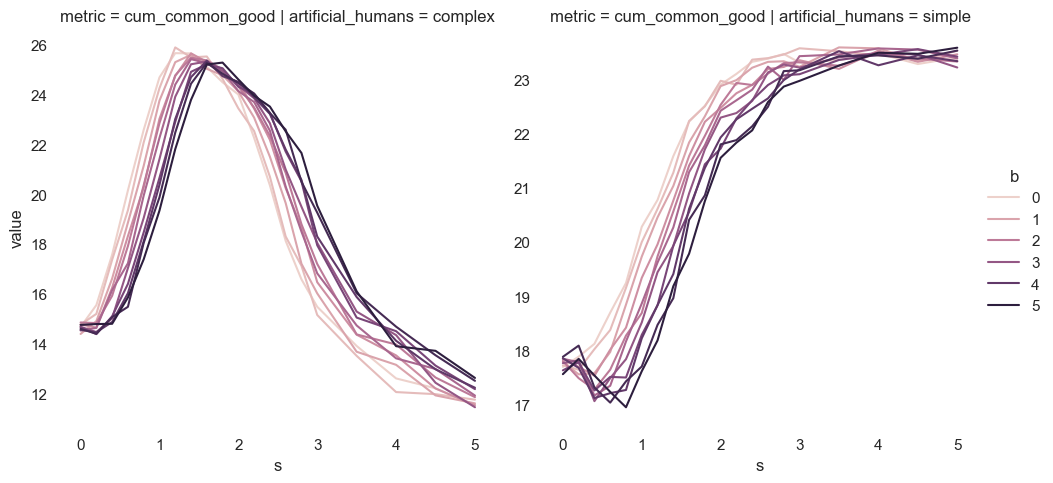

In [12]:
df = df_melt.copy()

w = (
    (df['c'] == 0) &
    # (df['b'] == 0) &
    df['round_number'].isin([15]) &
    (df['metric'].isin(['cum_common_good']))
)
df = df[w]

fg = sns.relplot(
    data=df, x='s', y='value', row='metric', col='artificial_humans', hue='b', kind='line', facet_kws={'sharey': False, 'sharex': True}, ci=None)


fg.savefig(os.path.join(plot_folder, 'common_good_s_b.jpg'))


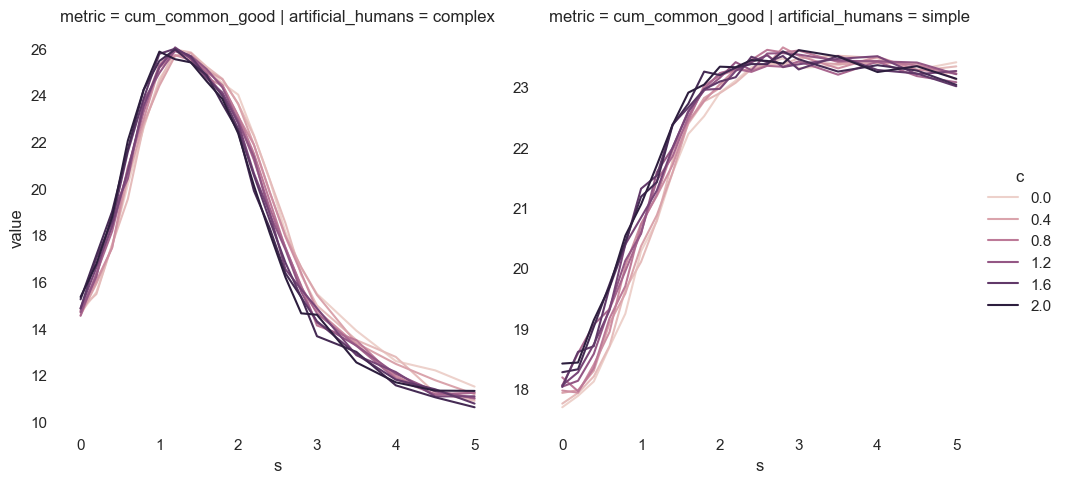

In [13]:
df = df_melt.copy()

w = (
    # (df['c'] == 0) &
    (df['b'] == 0) &
    df['round_number'].isin([15]) &
    (df['metric'].isin(['cum_common_good']))
)
df = df[w]

fg = sns.relplot(
    data=df, x='s', y='value', row='metric', col='artificial_humans', hue='c', kind='line', facet_kws={'sharey': False, 'sharex': True}, ci=None)


fg.savefig(os.path.join(plot_folder, 'common_good_s_c.jpg'))

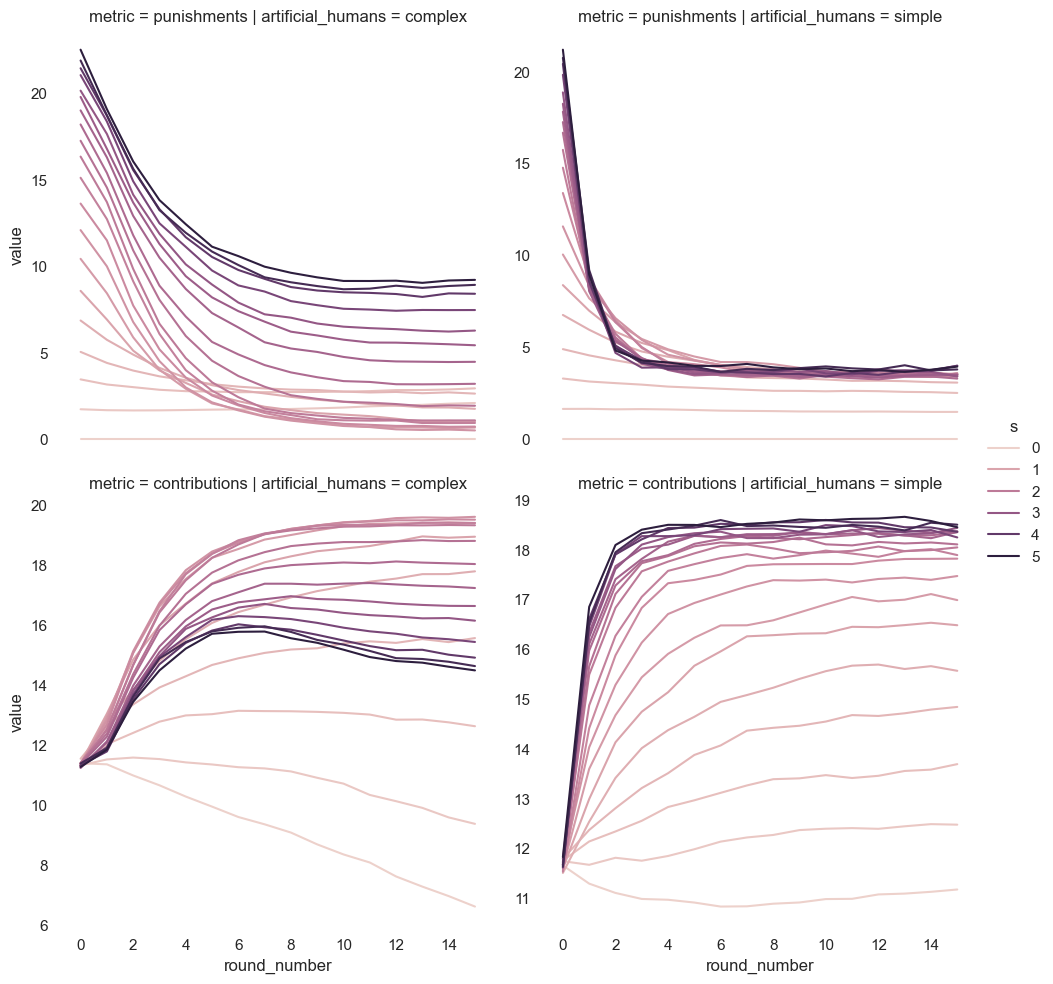

In [14]:
df = df_melt.copy()

w = (
    (df['c'] == 0) &
    (df['b'] == 0)  &
    # df['round_number'].isin([0,1,2,3,7,11,15]) &
    (df['metric'].isin(['contributions', 'punishments']))
)
df = df[w]


fg = sns.relplot(data=df, x='round_number', y='value', row='metric', col='artificial_humans', hue='s', kind='line', facet_kws={'sharey': False, 'sharex': True}, ci=None)


fg.savefig(os.path.join(plot_folder, 'over_rounds.jpg'))


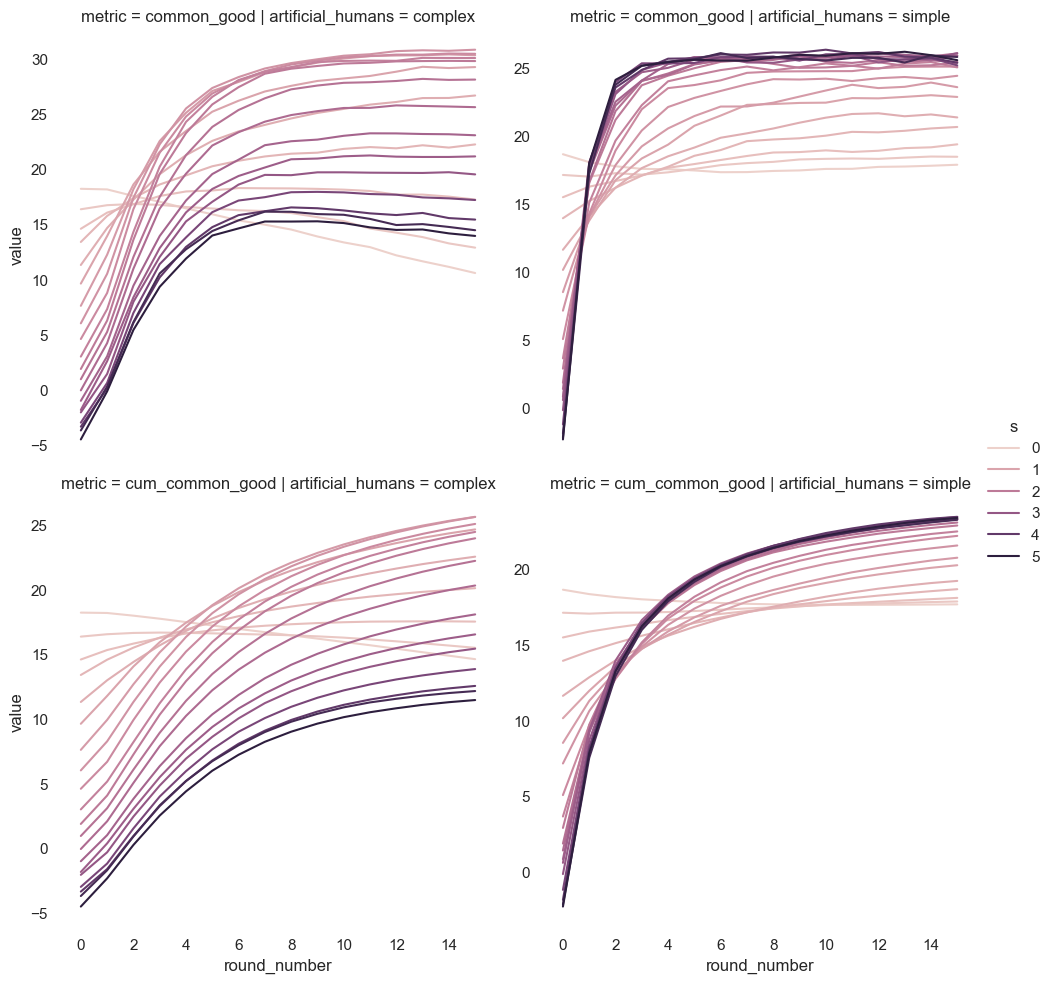

In [15]:
df = df_melt.copy()

w = (
    (df['c'] == 0) &
    (df['b'] == 0)  &
    # df['round_number'].isin([0,1,2,3,7,11,15]) &
    (df['metric'].isin(['common_good', 'cum_common_good']))
)
df = df[w]


fg = sns.relplot(data=df, x='round_number', y='value', row='metric', col='artificial_humans', hue='s', kind='line', facet_kws={'sharey': False, 'sharex': True}, ci=None)


fg.savefig(os.path.join(plot_folder, 'over_rounds_cg.jpg'))

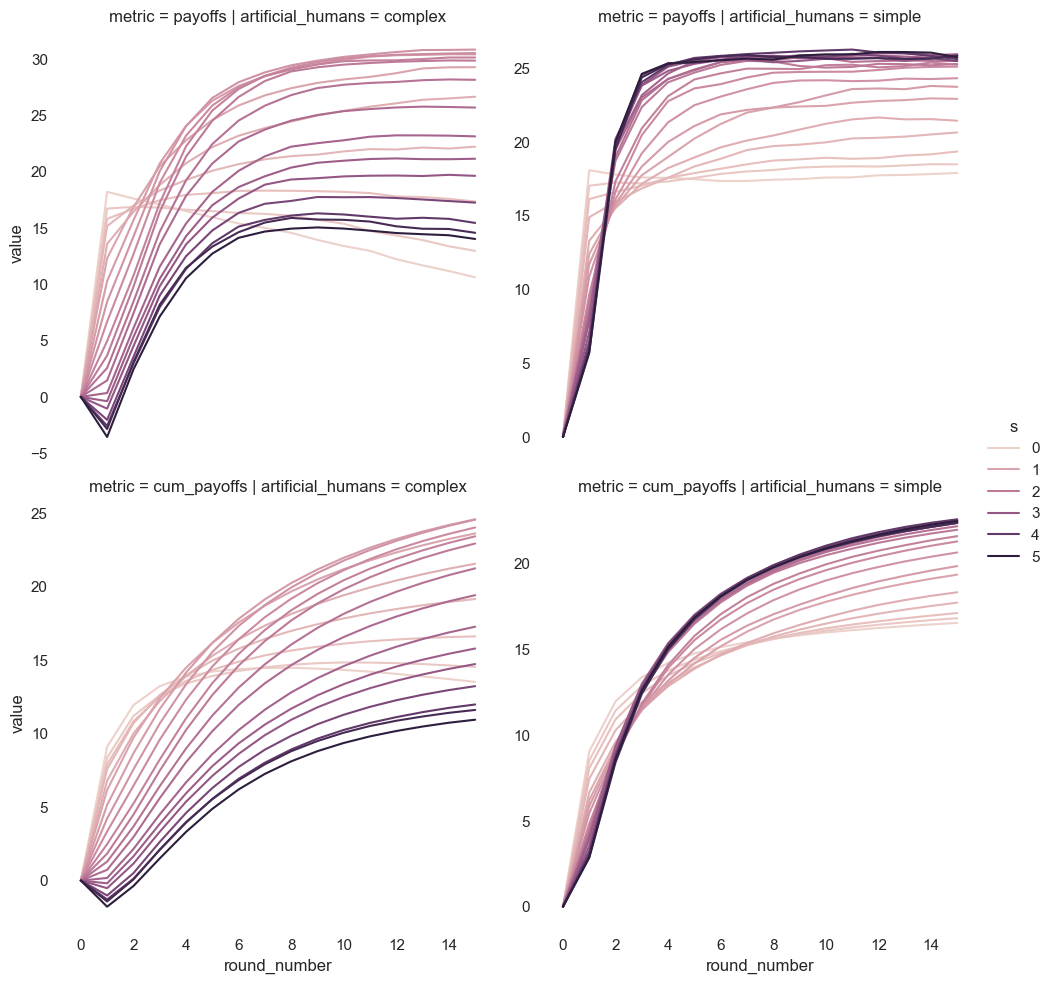

In [16]:
df = df_melt.copy()

w = (
    (df['c'] == 0) &
    (df['b'] == 0)  &
    # df['round_number'].isin([0,1,2,3,7,11,15]) &
    (df['metric'].isin(['payoffs', 'cum_payoffs']))
)
df = df[w]


fg = sns.relplot(data=df, x='round_number', y='value', row='metric', col='artificial_humans', hue='s', kind='line', facet_kws={'sharey': False, 'sharex': True}, ci=None)


fg.savefig(os.path.join(plot_folder, 'over_rounds_rew.jpg'))

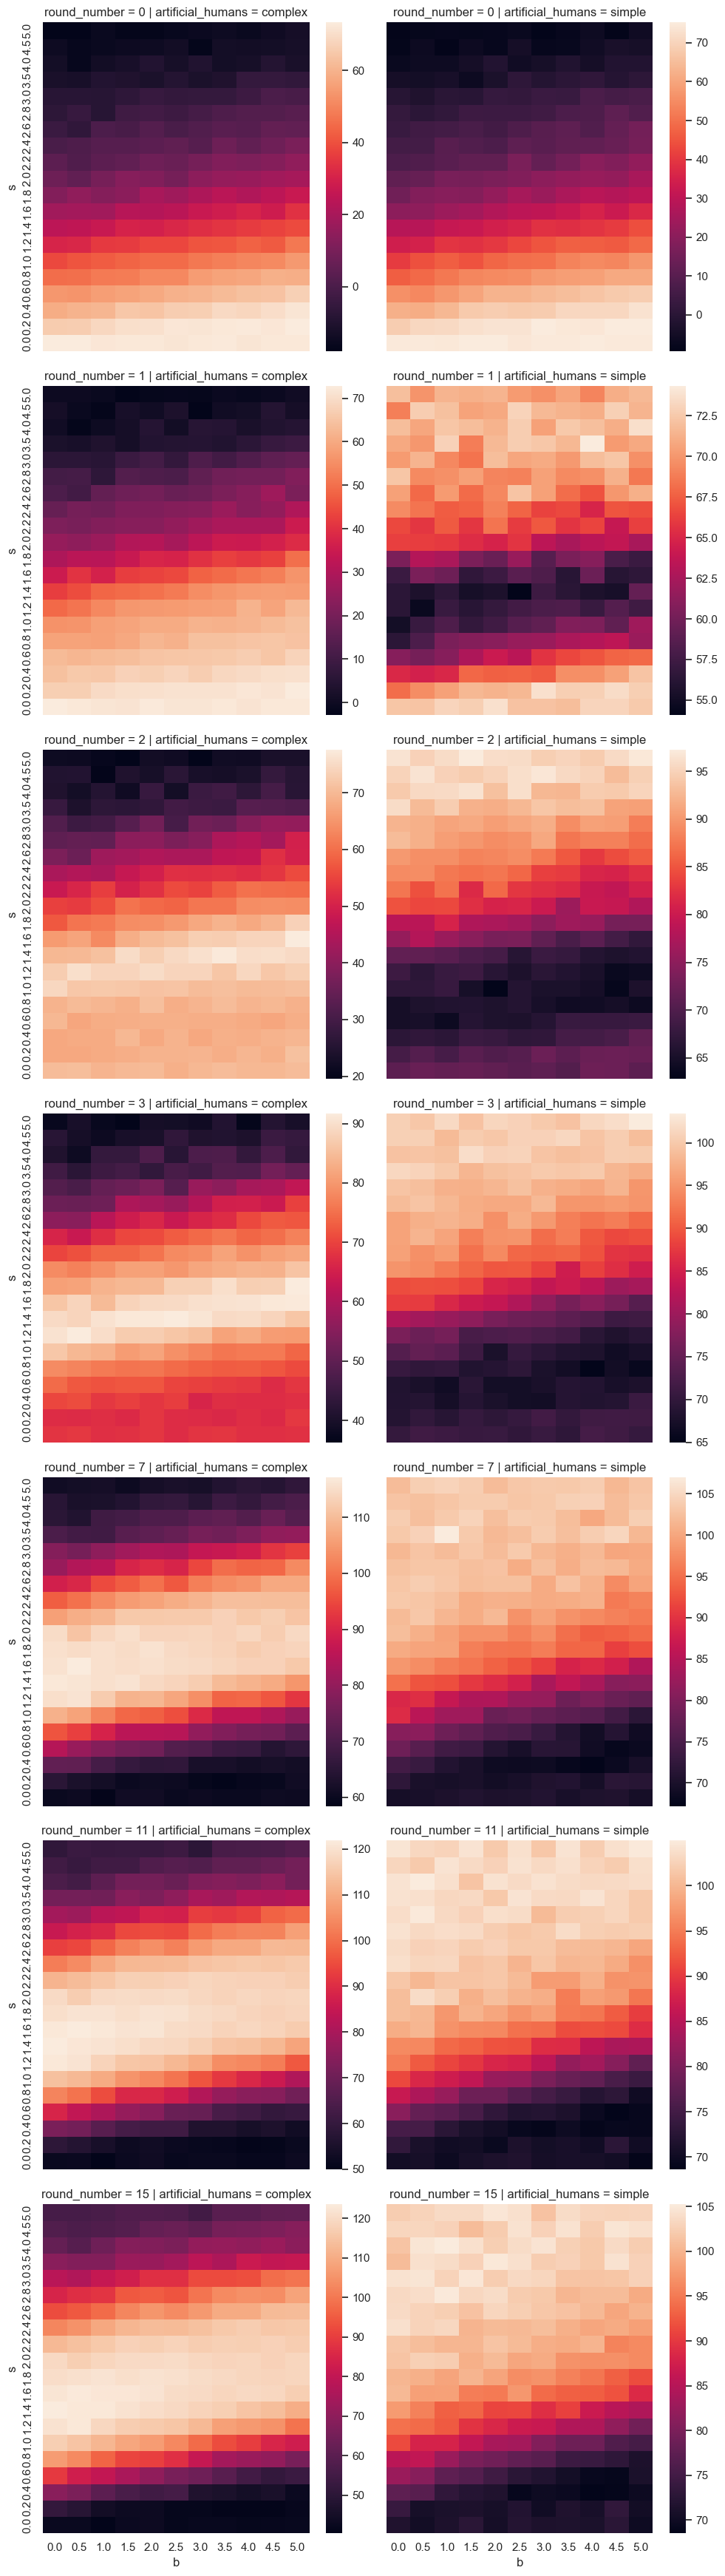

In [17]:
df = df_melt.copy()

w = (
    (df['c'] == 0) &
    df['round_number'].isin([0,1,2,3,7,11,15]) &
    (df['metric'] == 'common_good')
)
df = df[w]


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='s',y='b', values='value', normalise=False)

fg = sns.FacetGrid(
    df, row='round_number',
    col='artificial_humans',
    height=5)
fg.map_dataframe(plot_heatmap)

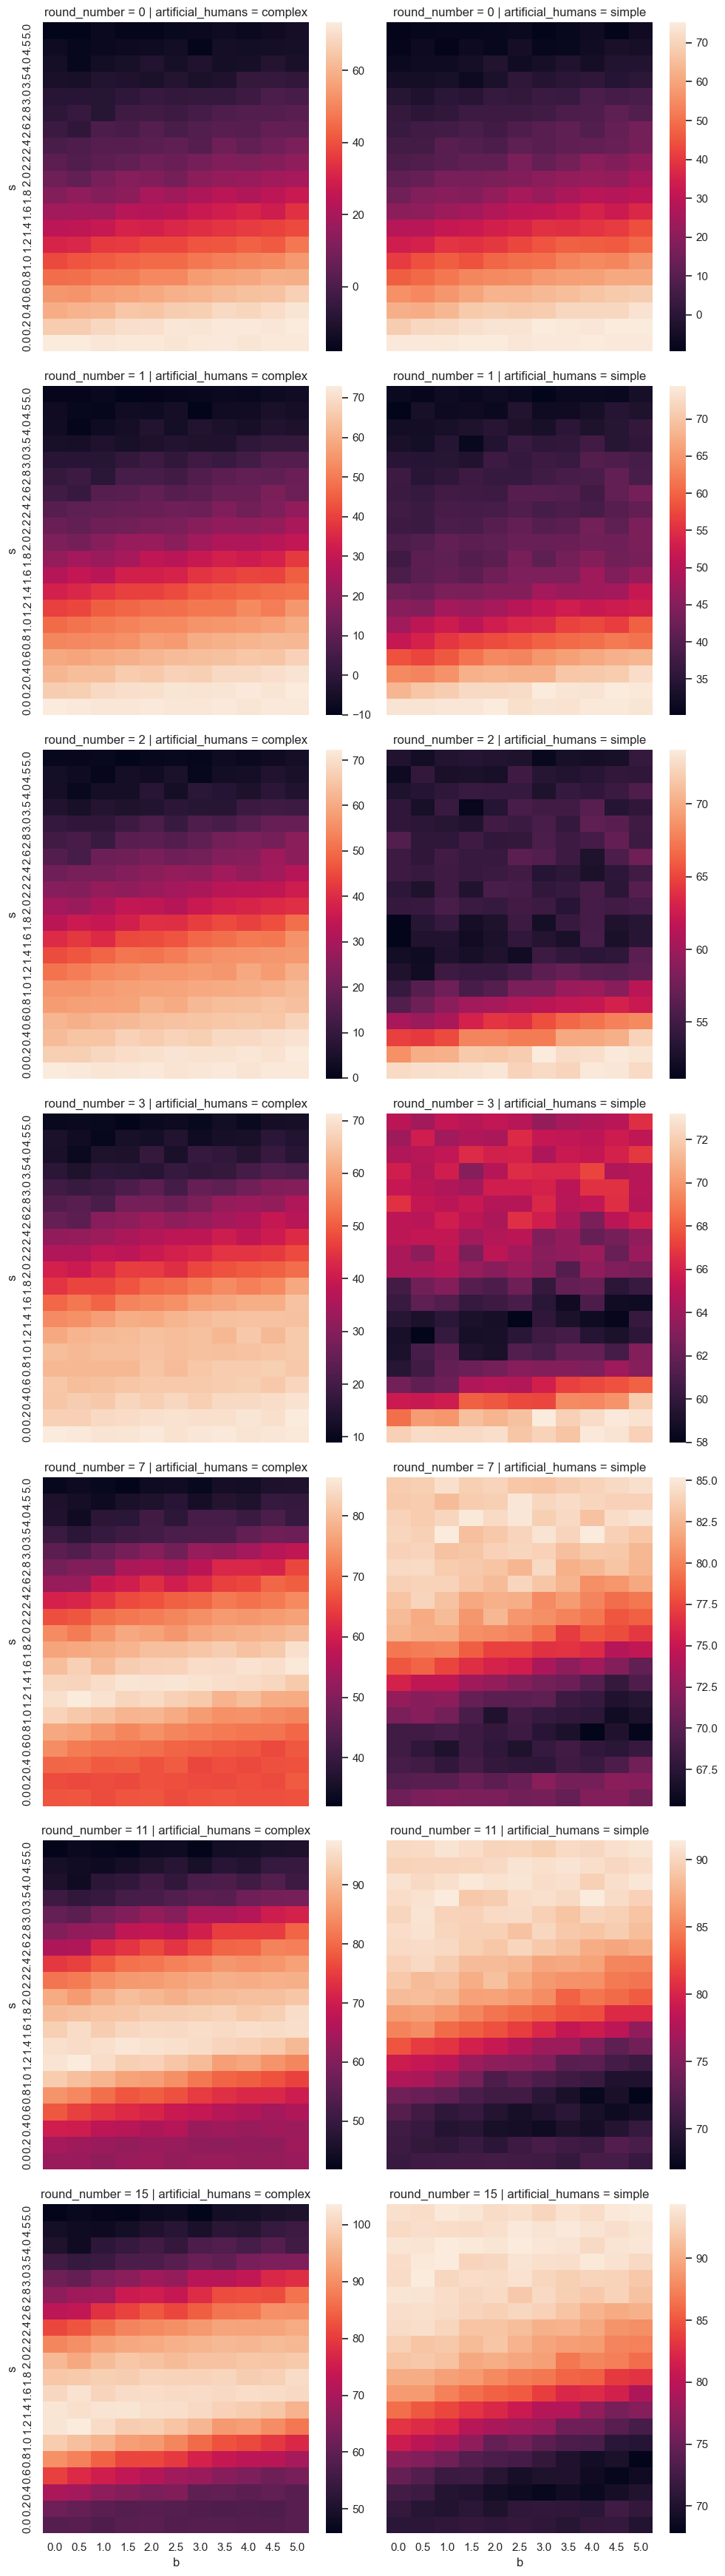

In [18]:
df = df_melt.copy()

w = (
    (df['c'] == 0) &
    df['round_number'].isin([0,1,2,3,7,11,15]) &
    (df['metric'] == 'cum_common_good')
)
df = df[w]


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='s',y='b', values='value', normalise=False)

fg = sns.FacetGrid(
    df, row='round_number',
    col='artificial_humans',
    height=5)
fg.map_dataframe(plot_heatmap)